#### **AML Assignment 05 : Transfer Learning**
#### **Task 02 : Sentiment Analysis using pre-trained Transformer**


- Name: Soumyajoy Kundu
- Roll No: MDS202349

----

* Transfer Learning for text data using Transformer

    * Download the sentiment analysis dataset from this link : [Click Here!](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset)
    * Build a sentiment analysis classifier to classify the sentiment into positive, neutral, and negative by fine-tuning a pre-trained transformer model
    * Print your classification report


### Importing Libraries

In [1]:
import os, sys, random, time, copy
import torch, warnings

import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.optim as optim
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamWeightDecay
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
with zipfile.ZipFile('/content/5.2_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

print("Files unzipped to the 'data' folder.")

Files unzipped to the 'data' folder.


* Loading the training and testing data

In [3]:
data_train = pd.read_csv("/content/data/train.csv", encoding="latin1")
data_test = pd.read_csv("/content/data/test.csv", encoding="latin1")

In [4]:
# Training dataframe
data_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
# Testing dataframe
data_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [6]:
data_train.shape, data_test.shape

((27481, 10), (4815, 9))

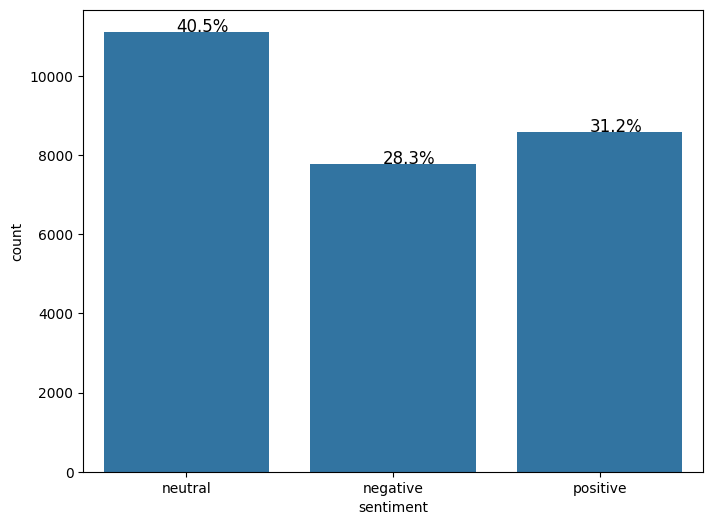

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=data_train['sentiment'])

total = len(data_train['sentiment'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)

plt.show()

* Comparitively the composition of all the sentiments are absolutely perfect.
* No need to take measures of data imabalance

In [7]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

print(device)

Using GPU:  True
cuda


* We just need `text` and `sentiment` column to train and evaluate our model for this study.

In [8]:
train_data = pd.DataFrame(data_train[['text', 'sentiment']])
test_data = pd.DataFrame(data_test[['text', 'sentiment']])

In [9]:
# Training data
train_data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [10]:
# Testing data
test_data.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


### Data Preprocessing

#### Training Data

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


* One row of the train dataset has a `NaN` value.
* As the number of null entries are very less, so we have just deleted the row.

In [12]:
# Displaying row with null value
train_data[train_data.isna().any(axis=1)]

,text,sentiment
314,NaN,neutral


In [13]:
# Dropping null value rows
train_data = train_data.dropna()

In [14]:
# Now we don't have any null values
train_data[train_data.isna().any(axis=1)]

,text,sentiment


#### Testing Data

In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 75.4+ KB


* There are around 1281 null value rows in test data
* We will remove them as test data is used to evaluate the model performance

In [16]:
test_data[test_data.isna().any(axis=1)].shape

(1281, 2)

In [17]:
# Dropping the null value rows
test_data = test_data.dropna()

In [18]:
# Now we don't have any null values
test_data[test_data.isna().any(axis=1)]

,text,sentiment


#### Labelling the sentiments
* Encoding the sentiments for modellling purpose
  * `negative : 0`
  * `neutral : 1`
  * `positive : 2`

In [19]:
label_map = {'positive': 2,
             'neutral': 1,
             'negative': 0}

# Ensuring the train and test data also gets encoded using the defined map
train_data['label'] = train_data['sentiment'].map(label_map)
test_data['label'] = test_data['sentiment'].map(label_map)

In [20]:
# Preview of the train data
train_data.head()

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0


### Transfer Learning

#### 1. Making the datasets
* We have to ensure that the train data and test data undergoes certain transforms to go well with the pre-trained model architecture.

In [21]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

#### 2. Pre-trained BERT model
* BERT : Bidirectional Encoder Representations from Transformers
* Importing pre-trained BERT model, with output dimension of 3
* As we have only three sentiments to deal with as the final output for a corresponding input.

In [22]:
# Defining a pre-trained model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Initialising the model to GPU
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

* Transforming the train and test data and creating data loader to train in batches.

In [23]:
train_dataset = CustomDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
test_dataset = CustomDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#### 3. Training the model -- [ Fine - Tuning ]

In [24]:
epochs = 5
learning_rate = 2e-5

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [30]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_batches += 1

        # Print loss for batch (only the multiples of 1000)
        if batch_idx %1000 == 999:
          print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    avg_loss = total_loss / total_batches
    print()
    print(f"Epoch {epoch+1}/{epochs}, Average Training Loss: {avg_loss}", end = "\n\n")

Epoch 1/5, Batch 1000/3435, Loss: 0.2534470558166504
Epoch 1/5, Batch 2000/3435, Loss: 0.5890153050422668
Epoch 1/5, Batch 3000/3435, Loss: 0.4262179136276245

Epoch 1/5, Average Training Loss: 0.5691158589024471

Epoch 2/5, Batch 1000/3435, Loss: 0.30297160148620605
Epoch 2/5, Batch 2000/3435, Loss: 0.16359226405620575
Epoch 2/5, Batch 3000/3435, Loss: 0.40143322944641113

Epoch 2/5, Average Training Loss: 0.40443470463932124

Epoch 3/5, Batch 1000/3435, Loss: 0.28156232833862305
Epoch 3/5, Batch 2000/3435, Loss: 0.2670607268810272
Epoch 3/5, Batch 3000/3435, Loss: 0.2146436721086502

Epoch 3/5, Average Training Loss: 0.25722201018346125

Epoch 4/5, Batch 1000/3435, Loss: 0.29786938428878784
Epoch 4/5, Batch 2000/3435, Loss: 0.23238424956798553
Epoch 4/5, Batch 3000/3435, Loss: 0.04005403071641922

Epoch 4/5, Average Training Loss: 0.15539008273859678

Epoch 5/5, Batch 1000/3435, Loss: 0.003944286610931158
Epoch 5/5, Batch 2000/3435, Loss: 0.007376404013484716
Epoch 5/5, Batch 3000/34

#### 4. Classification Report

In [31]:
model.eval()
true_labels = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]
        true_labels.extend(labels.tolist())
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())

print(classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.76      0.79      0.78      1001
     neutral       0.76      0.71      0.73      1430
    positive       0.81      0.85      0.83      1103

    accuracy                           0.78      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.77      0.78      0.77      3534



* The model performed with around 80% accuracy.

#### 5. Confusion Matrix

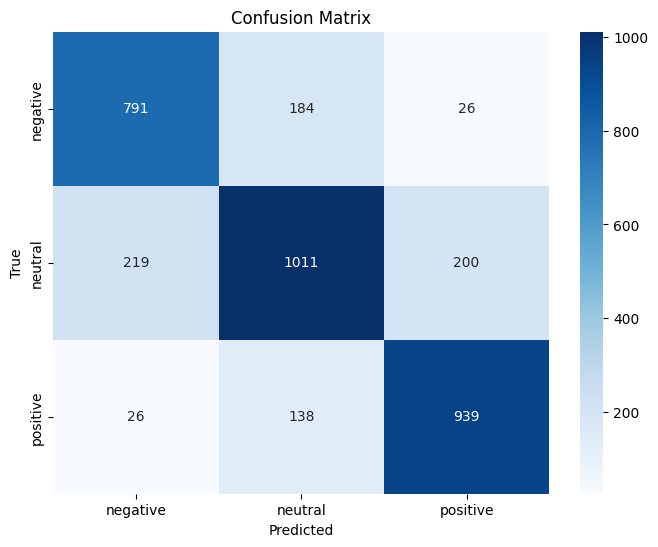

In [34]:
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### 6. Predictions

In [44]:
num_predictions_to_show = 10

random_indices = random.sample(range(len(true_labels)), num_predictions_to_show)

for index in random_indices:
    actual_label = true_labels[index]
    predicted_label = predictions[index]
    text = test_data['text'].iloc[index]  # Get the text from the test data

    # Decoding the labels that we have defined earlier
    actual_label = 'positive' if actual_label == 2 else ('neutral' if actual_label == 1 else 'negative')
    predicted_label = 'positive' if predicted_label == 2 else ('neutral' if predicted_label == 1 else 'negative')

    print(f"Text: {text}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 20)

Text:  He is the truth! But what about Maxwell? You can`t forget the future father of my children!
Actual Label: neutral
Predicted Label: positive
--------------------
Text:  ur Mom just called. Guess NOT. C U @ 5
Actual Label: neutral
Predicted Label: neutral
--------------------
Text:  i don`t want to do anything specific, i just want to see you and puppy!
Actual Label: neutral
Predicted Label: neutral
--------------------
Text:  yeah do you feel anything at all? I remembered I was looking at loopt on his phone and that **** was coughin all over that
Actual Label: negative
Predicted Label: negative
--------------------
Text: I honestly hate what I have said to some ppl sometimes. sorry for makin an **** of myself to anyone.
Actual Label: negative
Predicted Label: negative
--------------------
Text:  well piss on that. I can`t get into their site @ work nor does it come thru on my phone.
Actual Label: negative
Predicted Label: negative
--------------------
Text:  WHEW!  I`m just going

* Clearly, we can see that out of 10 randomly test inputs, only 1 was predicted wrong.
* Thus, our goal of fine-tuning the BERT model for sentiment analysis achieved a good accuracy.